<a href="https://colab.research.google.com/github/gregorywmorris/MLZoom2022/blob/main/midterm/Stroke_Prediction_MLZoomcamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Auto-save / Auto-reload
%autosave 1

%load_ext autoreload
%autoreload 2

Autosaving every 1 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Why Predicting Stroke Likelihood Matters





### By the Numbers
**Global**

Strokes are a global epidemic. They are the second leading cause of death and have increased by 70% between 1990 to 2019, with death from strokes inceasing by 43% ([source](https://www.thelancet.com/journals/laneur/article/PIIS1474-4422(21)00252-0/fulltext)). The WHO estimates the anual cost of strokes to be over US$721 billion ([source](https://pubmed.ncbi.nlm.nih.gov/34986727/#:~:text=Abstract,%25%20of%20the%20global%20GDP))).

**United States**

While strokes have been declining for decades in the US, it still has a large financial burden, amounting to $53 billion anually ([source](https://www.cdc.gov/stroke/facts.htm)). Currently stroke is the 5th leading cause of death in the US ([source](https://www.cdc.gov/nchs/fastats/leading-causes-of-death.htm)).

### Optimal Outcomes
**Global**

Predicting stroke can provide an opportunity to take corrective actions before a stroke occurs. Most importantly, resulting in fewer deaths and disabilities.

Addtionally, the money lost to strokes would boost econamies. Assuming cost and stroke occurance are linear, if strokes were reduced by just 5%, that would inject $36 billion into world economies.

**United States**

And $2.65 billion into the US econamy.

# Stroke Data

### An Appropriate Dataset
A seach for various stroke datasets that included health factors showed that the [Kaggle dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) was best suited. Numerous other stroke datasets are avaialbe but the lacked health factors needed. Datasets were often location based or even post stroke images. Neither are well suited for the the desired task.

### Limitations

* It is known that there are more factors for stroke prediction (such as [lab tests](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8686476/), lifestyle, etc.) than are avaialble in this data set.
  * However, [the most important factors](https://www.sciencedirect.com/science/article/pii/S2772442522000090) are in the dataset
* This data set was uploaded 2 years ago with no expectations of being updated.
* The source and accuracy to the data is unkown, a verified healthcare organization would be an ideal source for stroke data.

# Extract-Load-Transform (ELT)

## The Process


**Extract:** Data is extracted from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) to [GitHub](https://github.com/gregorywmorris/MLZoom2022/blob/main/midterm/healthcare-dataset-stroke-data.csvhttps://github.com/gregorywmorris/MLZoom2022/blob/main/midterm/healthcare-dataset-stroke-data.csv)

**Load:** Data is loaded to the notebook

**Transform:** Data is modified to suit and improve the model

### Load

In [134]:
data = 'https://raw.githubusercontent.com/gregorywmorris/MLZoom2022/main/midterm/healthcare-dataset-stroke-data.csv'

In [135]:
!wget $data -O data.csv

--2022-10-24 16:18:50--  https://raw.githubusercontent.com/gregorywmorris/MLZoom2022/main/midterm/healthcare-dataset-stroke-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 316971 (310K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>] 309.54K  --.-KB/s    in 0.007s  

2022-10-24 16:18:51 (41.9 MB/s) - ‘data.csv’ saved [316971/316971]



In [136]:
import pandas as pd
import numpy as np


In [137]:
df = pd.read_csv('data.csv')

### Transform - Cleanining and EDA

#### Data Cleaning

In [138]:
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


'id' column is not needed.

In [139]:
df = df.drop(columns='id')

In [140]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Column names are need to be normalized to all lower case (see Residence_type), bmi N/A needs to be adressed.

In [141]:
col = df.columns.tolist()

In [142]:
df = df.rename(str.lower, axis='columns')
col = df.columns.tolist() # list with new column names all lower case

In [143]:
df.describe() # statistiacal overview, look for outliers or oddities

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Average zeros based on groups of either possitive for stroke or not. Suspect possible difference in grouping.

In [144]:
stroke_mean_0, stroke_mean_1 =df.groupby('stroke')['bmi'].mean()
stroke_mean_0, stroke_mean_1 # 0 not a stroke and 1 is a stroke

(28.823063829787234, 30.471291866028707)

In [145]:
round((stroke_mean_1-stroke_mean_0)/stroke_mean_1,2)

0.05

Slight variance of 5% in bmi mean, note dtype is float64

In [147]:
stroke_0, stroke_1 =df.groupby('stroke')['bmi']

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: ignored

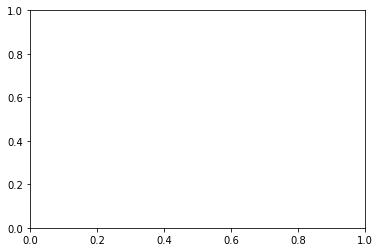

In [153]:
import matplotlib.pyplot as plt

plt.plot(stroke_0, df.bmi)

In [148]:
# two sample
from scipy.stats import ttest_ind
ttest_ind(stroke_0[1],stroke_1[1], nan_policy='omit',equal_var=False)

Ttest_indResult(statistic=-3.6404100561557073, pvalue=0.0003339710013121509)

In [149]:
# one sample
from scipy.stats import ttest_ind
ttest_ind(stroke_1[1],df.bmi, nan_policy='omit')

Ttest_indResult(statistic=2.865261001166529, pvalue=0.00418364223969314)

The p-value of 0.0003 in a two sample test and p-value of 0.004 on a one sample test tells us the difference in the bmi distributions are statistiacally signifigant. Replacing the missing values with the mean for the given stroke grouping is justified.

In [150]:
# Check for zeros in columns that it would not make sense to exist in. 

(df[col] == 0).all()

gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
residence_type       False
avg_glucose_level    False
bmi                  False
smoking_status       False
stroke               False
dtype: bool

#### Exploratory Data Analysis (EDA)

# Modeling

The modeling process is about creating a baseline to compare the tuning process against. 

# Tuning

The tuning process consists of adjusting and measuring model parameters, and, if needed, revisiting feature engineering.

# Deployment